<a href="https://colab.research.google.com/github/TarkanAl-Kazily/awbw_replay_parser/blob/main/AWBW_Replays_Interactive_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the AWBW Replay Parser project!

This interactive notebook will introduce you to the replay parsing library, and demonstrate how to use it to plot data from your AWBW matches.

This notebook and the source code is all hosted on Github here: [https://github.com/TarkanAl-Kazily/awbw_replay_parser](https://github.com/TarkanAl-Kazily/awbw_replay_parser)

## Prerequisites

You will need need to have an AWBW Replay file that conforms to the newer .zip replay format. To access AWBW Replays, you must have an AWBW account and download them before they are deleted from the site. Because an account is required, it's currently not possible to automatically download replays through this notebook. Older replays _might_ work, but the results may be inaccurate.

Ideally to fully use this notebook, you have some familiarity with Python and matplotlib to to customize the displayed data from your replay. If you wish to contribute and make changes to this notebook or the repo itself, you will need a Github account and make a pull request (following the [contribution guide](https://github.com/TarkanAl-Kazily/awbw_replay_parser/blob/main/CONTRIBUTING.md)).


## Notebook Setup

In order to use the `awbw_replay_parser` code from Google Colab, we first have to clone the repository and install any missing Python modules. This block only needs to be ran once.

__IMPORTANT__: Restart the kernel after running this step - __Runtime -> Restart Runtime__ or __Ctrl+M+.__

If you need to install any additional Python modules, you can do so directly here with `!pip install <module>`. Note that at the time of writing, Google Colab's Python kernel version is fixed to Python 3.7.

You should be able to safely restart the Python kernel at anytime afterwards without needing to rerun this step. You only need to rerun this step if you want to pull updated changes from the Github repository.

In [ ]:
import os

os.environ['REPO'] = "https://github.com/TarkanAl-Kazily/awbw_replay_parser.git"
os.environ['BRANCH'] = "main"

# Clone the awbw_replay_parser repository
!cd /content/
!rm -rf awbw_replay_parser
!git clone --branch $BRANCH $REPO
!pip install -r awbw_replay_parser/requirements.txt

# Install the awbw_replay module into our runtime
!cd awbw_replay_parser && python setup.py install

## Parsing a Replay

Now that the codebase is downloaded and the notebook is setup, we can start analyzing replays. To analyze your own replay, use the sidebar and upload your replay (in its original `.zip` format). Alternatively, there are a few example replays included in the repository under `awbw_replay_parser/replays/`. With Google Colab, you can also mount your Google Drive to access cloud files directly.

This code block will load the replay and parse it into the list of game states.

In [6]:
from awbw_replay.awbw import AWBWGameState, AWBWGameAction
from awbw_replay.replay import AWBWReplay

REPLAY_FILE = "awbw_replay_parser/replays/standard_replay.zip"

states = []
with AWBWReplay(REPLAY_FILE) as replay:
  print(f"Opened {replay.path()}, containing {len(replay.turns())} turns")

  states.append(AWBWGameState(replay_initial=replay.game_info()))

  for action in replay.actions():
    states.append(states[-1].apply_action(AWBWGameAction(action)))

  print(f"Parsed replay into {len(states)} game states")


Opened awbw_replay_parser/replays/standard_replay.zip, containing 22 turns
Resign action
IMPLEMENT ME
Parsed replay into 285 game states


## Analyzing the Replay

Let's try to answer the question: Which player used their funds more effectively over the course of the match?

To do this, we can examine each state's `players` attribute, which contains a dictionary of player information by player ID. The player information is described by the `awbw_replay.awbw.Player` class as dictionary, and specifically contains the `"funds"` key.

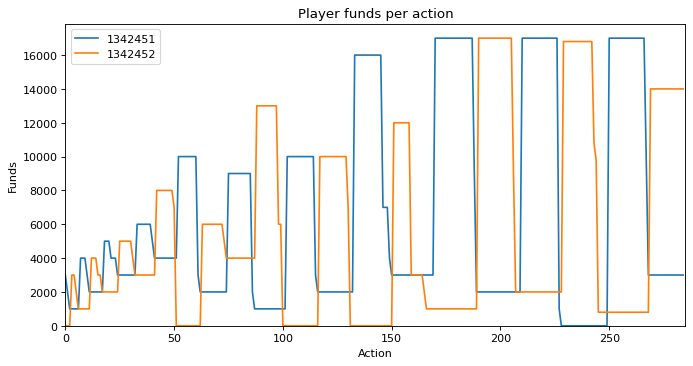

In [7]:
player_info = {}
player_ids = states[0].players.keys()
for p_id in player_ids:
  player_info[p_id] = {
      "users_id": p_id,
      "funds_by_action": []
  }

# Find the funds for each player after each action:
for state in states:
  for p_id in player_ids:
    player_info[p_id]["funds_by_action"].append(state.players[p_id]["funds"])


# Plot the data
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 5), dpi=80)
ax1 = fig.add_subplot()

for p_id, player in player_info.items():
    ax1.plot(player["funds_by_action"], label=player["users_id"])

ax1.set_xlim([0, len(states)])
ax1.set_ylim(0)
ax1.set_xticks(range(0, len(states), 50))
ax1.legend()

ax1.set_title("Player funds per action")
ax1.set_ylabel("Funds")
ax1.set_xlabel("Action")

fig.show()

Examining the replay by action isn't as useful. Let's filter the states to extract just the states where a new turn or day occurs, then replot our funds data.

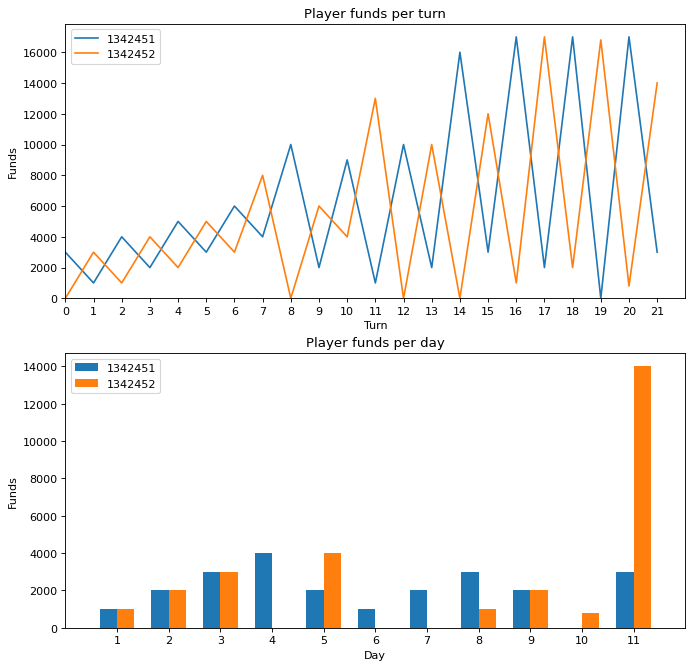

In [8]:
# Turn states will be the game states at the start of each player's turn
turn_states = []
for state in states:
  # The first state is always the start of someone's turn
  if len(turn_states) == 0:
    turn_states.append(state)
  elif state.game_info["turn"] != turn_states[-1].game_info["turn"]:
    turn_states.append(state)

# Day states will be the game state just before each new day, so that all players have the same number of income phases
day_states = []
for state, next_state in zip(states[:-1], states[1:]):
  if state.game_info["day"] != next_state.game_info["day"]:
    day_states.append(state)

# The last state is always the end of a day
day_states.append(states[-1])

for p_id in player_ids:
  player_info[p_id]["funds_by_turn"] = []
  player_info[p_id]["funds_by_day"] = []

for state in turn_states:
  for p_id in player_ids:
    player_info[p_id]["funds_by_turn"].append(state.players[p_id]["funds"])

for state in day_states:
  for p_id in player_ids:
    player_info[p_id]["funds_by_day"].append(state.players[p_id]["funds"])

fig = plt.figure(figsize=(10, 10), dpi=80)
# Turn by turn plot
ax1 = fig.add_subplot(211)
ax1.set_title("Player funds per turn")
# Day by day plot
ax2 = fig.add_subplot(212)
ax2.set_title("Player funds per day")

bar_offsets = np.linspace(-0.5, 0.5, num=len(player_info) + 2)
bar_positions = np.arange(1, len(day_states) + 1)
bar_width = 1.0 / (len(player_info) + 1)

for i, (p_id, player) in enumerate(player_info.items()):
    ax1.plot(player["funds_by_turn"], label=player["users_id"])
    ax2.bar(bar_positions + bar_offsets[i+1], player["funds_by_day"], width=bar_width, label=player["users_id"])

ax1.set_xlim([0, len(turn_states)])
ax2.set_xlim([0, len(day_states) + 1])
ax1.set_xticks(range(0, len(turn_states)))
ax2.set_xticks(bar_positions)
ax1.set_xlabel("Turn")
ax2.set_xlabel("Day")

for ax in [ax1, ax2]:
  ax.set_ylabel("Funds")
  ax.legend()
  ax.set_ylim(0)

plt.show()

## Getting Fancy

We've examined the state directly through the player's `"funds"` key. Now lets extract more useful information from our states using _math_.

A common AWBW metric is the concept of army value, which is given by the formula:

$$\sum_{u \in \text{Units}} u_{\text{cost}} \frac{u_{\text{hp}}}{u_{\text{max_hp}}}$$

We can implement this metric as a function of game state and graph it for each player at the end of each day to get a sense of who has taken better engagements and used their funds more effectively.

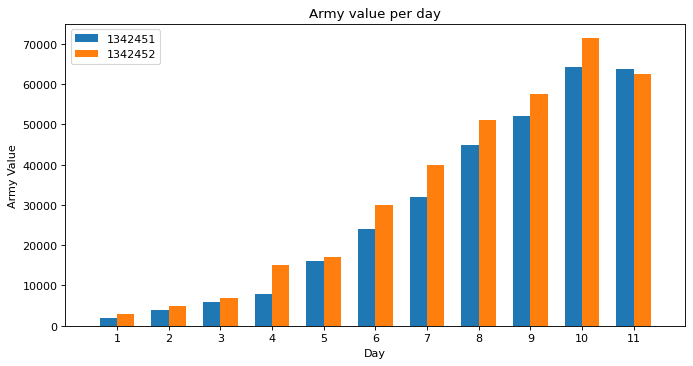

In [9]:
MAX_HEALTH = 10.0

def army_value(state, player_id):
  """
  Computes the given player's army value, which is calculated as the sum of
  that player's units cost weighted by that unit's health (as a percentage).

  Arguments:
  - state: AWBWGameState object to get the army value from.
  - player_id: int for which player to compute army value for.
  """
  result = 0
  for unit in state.units.values():
    # Skip units that aren't the given player's
    if not unit["players_id"] == player_id:
      continue
    result += unit["cost"] * unit["hit_points"] / MAX_HEALTH
  
  return result

for p_id in player_ids:
  player_info[p_id]["army_value_by_day"] = []

for state in day_states:
  for p_id in player_ids:
    player_info[p_id]["army_value_by_day"].append(army_value(state, p_id))

fig = plt.figure(figsize=(10, 5), dpi=80)
ax1 = fig.add_subplot(111)
ax1.set_title("Army value per day")

for i, (p_id, player) in enumerate(player_info.items()):
    ax1.bar(bar_positions + bar_offsets[i+1], player["army_value_by_day"], width=bar_width, label=player["users_id"])

ax1.set_xlim([0, len(day_states) + 1])
ax1.set_xticks(bar_positions)
ax1.set_xlabel("Day")
ax1.set_ylabel("Army Value")
ax1.legend()
ax1.set_ylim(0)

plt.show()